## Importing the basic Libraries needed

In [3]:
!pip install category_encoders

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from category_encoders import CatBoostEncoder

import warnings
warnings.filterwarnings("ignore")

## Dataset Loading 

In [5]:
#data_usage = pd.read_parquet("data_usage_production.parquet")
#data_usage.set_index("telephone_number", inplace=True)
#data_usage.head()

data_usage = pd.read_parquet("data_usage_production.parquet") # first I have tried the full dataset, however, due to the large amount of data
# I had to use the sample of 20000 rows for memory efficiency 
data_usage = data_usage.sample(n=20000, random_state=42)
data_usage.set_index("telephone_number", inplace=True)
data_usage.head()

,tariff_desc,customer_status,tenure,data_compl_usg_local_m2,data_amount_lte_m2,data_pack_usg_m2,dpi_https_and_default_m2,data_pack_rev_local_m2,refill_total_m2,dpi_tik_tok_m2,...,data_tariff_revenue_m2,data_from_tariff_m3,data_tariff_revenue_m3,data_from_tariff_m4,data_tariff_revenue_m4,data_from_tariff_m5,data_tariff_revenue_m5,data_from_tariff_m6,data_tariff_revenue_m6,data_compl_usg_local_m1
telephone_number,,,,,,,,,,,,,,,,,,,,,
B59kYFgOZg,Bolge,Active,4226,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
ZC_SHd_H7r,Azercellim,Active,1212,10500.0,10497.0,0.0,36.0,14.0,20.0,10055.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12496.18
Iukgk3yWay,Bolge,Suspended,1384,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
VzyD3j1Y3o,Bolge,Suspended,1475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02
psUqbRH5FC,Azercellim,Suspended,2802,22.0,22.0,22.0,1.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02


## Missing values check

In [6]:
missing_values = data_usage.isnull().sum()

missing_values[missing_values > 0] 

Series([], dtype: int64)

## Train-Test Split

In [7]:
X = data_usage.drop(columns="data_compl_usg_local_m1")
y = data_usage["data_compl_usg_local_m1"] # we need to predict the data_compl_usg_local_m1 based on the info from the x, 
# so data_compl_usg_local_m1 has to be in y so it can predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20 method (20 on test)

## Feature Classification

In [8]:
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

## Division of Features

In [9]:
numerical_pipeline = Pipeline(steps=[ # numerical
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_pipeline = Pipeline(steps=[ # categorical
    ("encoder", CatBoostEncoder())
])

## Column Transformer

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ("num", numerical_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

## Model Pipeline and Fitting of the Model

In [11]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['tenure',
                                                   'data_compl_usg_local_m2',
                                                   'data_amount_lte_m2',
                                                   'data_pack_usg_m2',
                                                   'dpi_https_and_default_m2',
                                                   'data_pack_rev_local_m2',
                                                   'refill_total_m2',
                                                   'dpi_tik_tok_m2',
                                                   'dpi_youtube_m2',
                                                   'dpi_insta...
                                                   'data_compl_usg_local_m4',
                                                   'dpi_tik_tok_m4',
                                                   'dpi_tcp_signaling_m4',
                                                   'data_payg_rev_local_m4',
                                                   'data_compl_usg_local_m5', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   CatBoostEncoder())]),
                                                  ['tariff_desc',
                                                   'customer_status',
                                                   'lasttariff_m2',
                                                   'lasttariff_m3',
                                                   'lasttariff_m4',
                                                   'lasttariff_m5',
                                                   'lasttariff_m6'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## Final Evaluation

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.3f}")

MAE: 1099.76
MSE: 12226848.96
R²: 0.718


## Visualization of the Predicted vs Actual

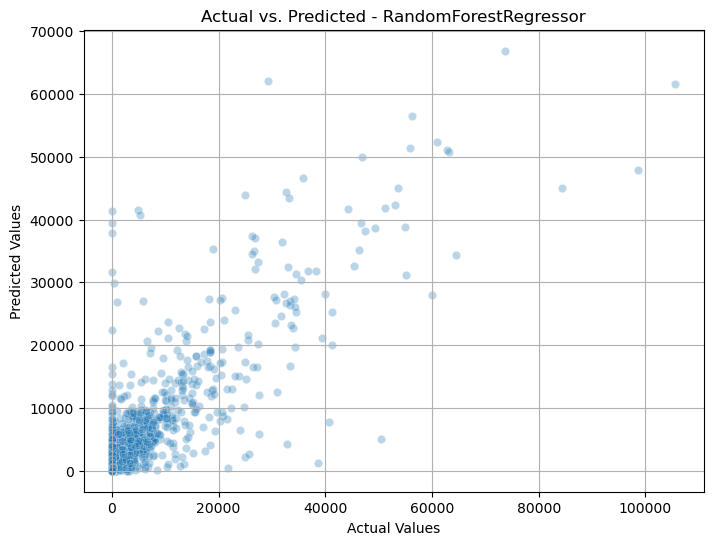

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted - RandomForestRegressor")
plt.grid(True)
plt.show()